### Intrinsic Dimension Estimation Pipeline
#### Description: Demo pipeline for estimating intrinsic dimension using global methods and local Full Correalion Integral
 This notebook provides a pipeline for estimating the intrinsic dimension (ID) of datasets using:
 1. **Global methods**: 
    - Two Nearest Neighbors (2NN)
    - Fractal Correlation Integral (FCI)
 2. **Local FCI**: 
    - Local FCI (lFCI) pipeline as proposed in "Exploring neural manifolds across a wide range of intrinsic dimensions"
 
This notebook is a demo on how to obtain results contained in "Exploring neural manifolds across a wide range of intrinsic dimensions". 

#### 1. Imports and Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from pathlib import Path
from typing import Tuple, Dict, Any, Optional, Callable
import warnings

# Custom functions (you should have "lfci_functions.py" in the same directory)
from lfci_functions import HypercubeGenerator, compute_global_ids, plot_id_results_comparison, extract_lfci_estimate, compute_local_fci


/opt/homebrew/anaconda3/envs/machine_learning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. Main Pipeline   

In [2]:
def run_id_pipeline(data: np.ndarray,
                   data_name: str = "custom_data",
                   output_dir: str = "results",
                   lfci_params: Dict[str, Any] = None,
                   KDE_params: Dict[str, Any] = None,
                   save_results: bool = True) -> Dict[str, Any]:
    """
    Main pipeline for intrinsic dimension estimation.
    
    Parameters
    ----------
    data : np.ndarray
        Input data of shape (n_samples, n_features)
    data_name : str
        Name for saving results
    output_dir : str
        Directory to save results
    lfci_params : Dict[str, Any]
        Parameters for lFCI computation. Suggested:
        {
            'n_neighbors': x, #depends on data size
            'n_centers': x, #depends on data size
            'fci_method': 'full',
            'n_jobs': 1,
            'delta_thr': 2.0,
            'ci_interval': (10, 90)
        }
    KDE_params : Dict[str, Any]
        Parameters for KDE peak detection. Suggested:
        {
            'bandwidth': 0.3,
            'x_min': 0, #depends on data
            'x_max': x, #depends on data
            'n_points_peak': 300
        }
    save_results : bool
        Whether to save results to HDF5 file
    
    Returns
    -------
    Dict[str, Any]
        Dictionary containing all results
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Running ID pipeline for {data_name}")
    print(f"Data shape: {data.shape}")
    
    # 1. Compute global ID estimates
    print("\n1. Computing global ID estimates...")
    global_results = compute_global_ids(data, methods=("2NN", "FCI"))
    
    for method, value in global_results.items():
        print(f"   {method}: {value:.3f}")
    
    # 2. Compute local FCI estimates
    print("\n2. Computing local FCI estimates...")
    ids, deltas, k, gof, neighborhoods = compute_local_fci(
        data,
        n_neighbors=lfci_params['n_neighbors'],
        n_centers=lfci_params['n_centers'],
        fci_method=lfci_params['fci_method'],
        n_jobs=lfci_params['n_jobs']
    )
    quartiles_delta = np.percentile(deltas, [5, 50, 99])
    hist_delta, edges_delta = np.histogram(deltas, bins=100)
    quartiles_gof = np.percentile(gof, [5, 50, 99])
    
    print(f"   Computed {len(ids)} local estimates")
    
    # 3. Extract lFCI estimate with filtering
    print("\n3. Extracting lFCI estimate with quality filters...")
    lfci_processed = extract_lfci_estimate(
        ids, deltas, k, gof, neighborhoods,
        delta_thr=lfci_params['delta_thr'],
        ci_interval=lfci_params['ci_interval'],
        KDE_params=KDE_params
    )
    

    print(f"   lFCI peak estimate: {lfci_processed['id_peak']:.3f}")
    print(f"   Confidence interval: [{lfci_processed['ci_id'][0]:.3f}, {lfci_processed['ci_id'][1]:.3f}]")
    print(f"   Points after filtering: {lfci_processed['n_filtered']}/{len(ids)}")
    
    # 4. Save results if requested
    results = {
        'data_name': data_name,
        'data_shape': data.shape,
        'global_ids': global_results,
        'lfci_raw': {
            'ids': ids,
            'deltas': deltas,
            'k': k,
            'gof': gof
        },
        'lfci_processed': lfci_processed,
        'parameters': lfci_params
    }
    
    if save_results:
        filename = output_path / f"id_results_{data_name}.h5"
        with h5py.File(filename, 'w') as f:
            # Save metadata
            f.attrs['data_name'] = data_name
            f.attrs['data_shape'] = data.shape
            
            # Save global results
            for method, value in global_results.items():
                f.attrs[f'global_{method}'] = value
            
            # Save raw lFCI data
            f.create_dataset('lfci_ids', data=ids)
            f.create_dataset('lfci_deltas', data=deltas)
            f.create_dataset('lfci_k', data=k)
            f.create_dataset('lfci_gof', data=gof)
            
            # Save processed results
            f.attrs['lfci_gof_thr'] = lfci_processed['gof_thr']
            f.attrs['lfci_id_peak'] = lfci_processed['id_peak']
            f.attrs['lfci_ci_lower'] = lfci_processed['ci_id'][0]
            f.attrs['lfci_ci_upper'] = lfci_processed['ci_id'][1]
        
        print(f"\nResults saved to: {filename}")
    
    return results


#### 3. Example pipeline with Hypercube data (with exponential embedding) 

Example: Replicate original hypercube analysis using samller parameters to make computation faster.
EXAMPLE 1: Hypercube with Exponential Embedding
True ID: 2, Alpha: 2.0
Running ID pipeline for hypercube_ID2_alpha2.0
Data shape: (1000, 100)

1. Computing global ID estimates...
No identical identical points were found
   2NN: 2.056
   FCI: 1.986

2. Computing local FCI estimates...
   Computed 100 local estimates

3. Extracting lFCI estimate with quality filters...
   GoF threshold determined: 0.009959566667675971 as 99th percentile at k = 556.0
   lFCI peak estimate: 1.919
   Confidence interval: [1.826, 2.007]
   Points after filtering: 53/100

Results saved to: results/id_results_hypercube_ID2_alpha2.0.h5
Plot saved to: results/hypercube_ID2_alpha2.0results.png


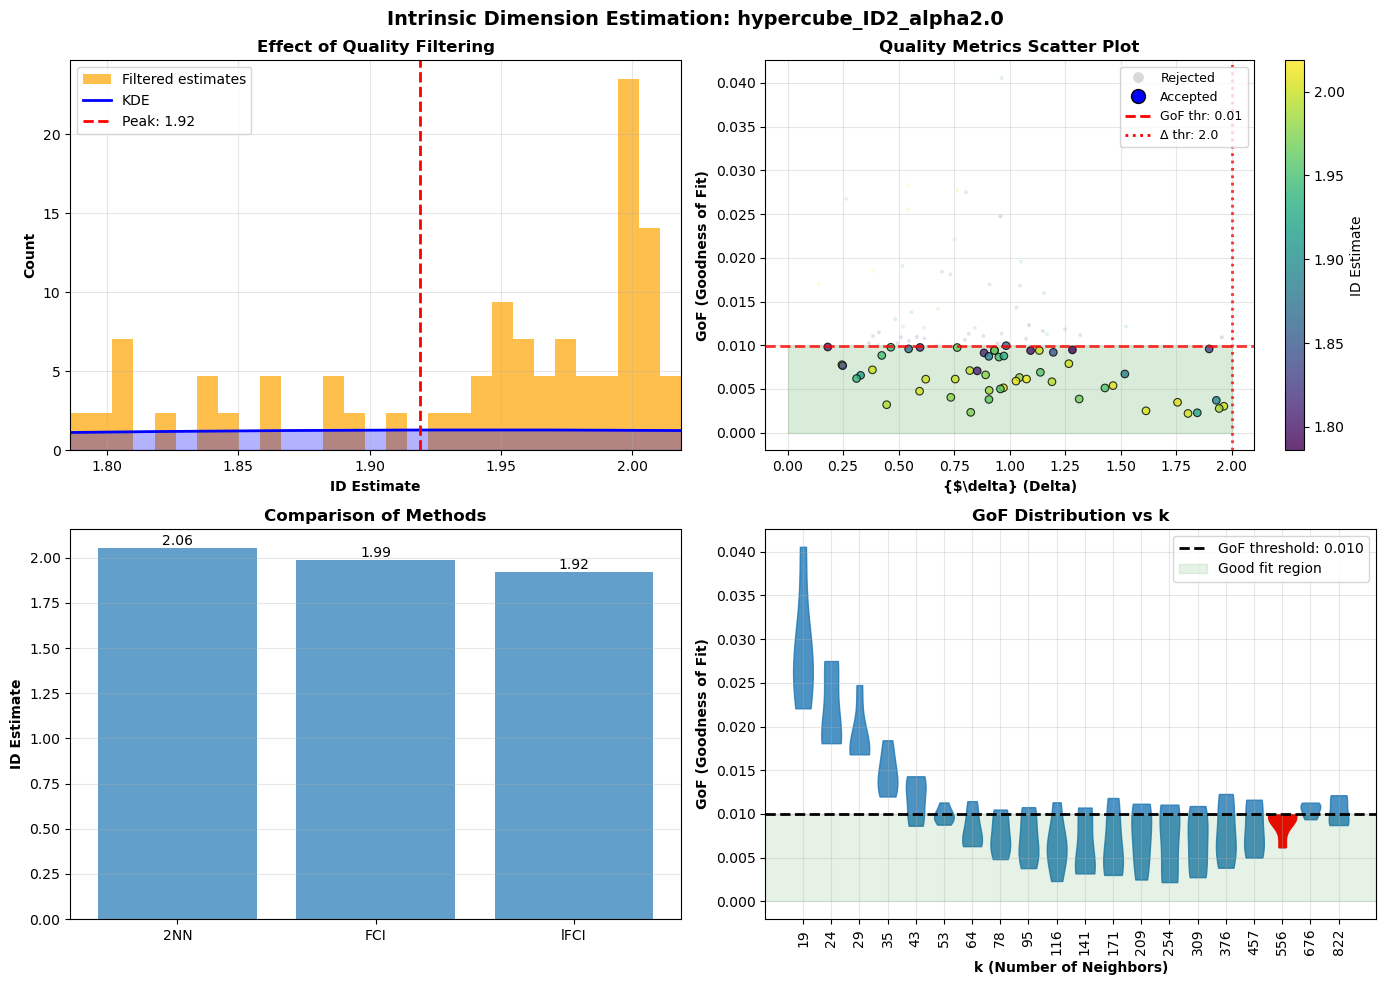


Pipeline execution complete!


In [3]:

print("=" * 60)
print(f"Example: Replicate original hypercube analysis using samller parameters to make computation faster.")
print("=" * 60)
print("EXAMPLE 1: Hypercube with Exponential Embedding")
print("=" * 60)

# Set up result directory
result_dir = "results"
os.mkdir(result_dir) if not os.path.exists(result_dir) else None    

# Parameters
rng = np.random.default_rng(42)
n_samples = 1000 # to obtain results from the paper, use 10000
ambient_dim = 100 # to obtain results from the paper, use 1000
intrinsic_dim = 2 # to obtain results from the paper, use 2,3,4,5,6
alpha = 2.0 # hyperparameters for the exponential embedding, to obtain results from the paper, use 0,1,2,3

# Create generator
generator = HypercubeGenerator(
    intrinsic_dim=intrinsic_dim,
    ambient_dim=ambient_dim,
    alpha=alpha,
    random_seed=42
)

# Generate data
data = generator.generate(n_samples)
print(f"True ID: {intrinsic_dim}, Alpha: {alpha}")

# Run pipeline with small parameters, toy setting
results = run_id_pipeline(
    data=data,
    data_name=f"hypercube_ID{intrinsic_dim}_alpha{alpha}",
    output_dir=result_dir,
    lfci_params={
        'n_neighbors': 20, # to obtain results from the paper, use 20
        'n_centers': 5, # to obtain results from the paper, use 100
        'fci_method': 'full',
        'n_jobs': 1,
        'delta_thr': 2.0,
        'ci_interval': (10, 90)
    },
    KDE_params={
            'bandwidth': 0.3,
            'x_min': 0, #depends on data
            'x_max': 5, #depends on data
            'n_points_peak': 100
        },
    save_results=True
)

# Visualize
plot_id_results_comparison(results, save_path=f"{result_dir}/hypercube_ID{intrinsic_dim}_alpha{alpha}results.png")

print("\n" + "=" * 60)
print("Pipeline execution complete!")
print("=" * 60)

 #### 9. Use the pipeline with synthetic neural data

In [ ]:
print("\n" + "=" * 60)
print(f"Example 2: Replicate ID estimation for synthetic neural data analysis using samller parameters to make computation faster.")
print("\n" + "=" * 60)
print(f"EXAMPLE 2: Synthetic neural data ")
print("=" * 60)

# Set up result directory
result_dir = "results"
os.mkdir(result_dir) if not os.path.exists(result_dir) else None

#Load data
true_dim = 10 #to replicate results from the paper, use 3,6,10,20,40
data_type = "exp" # choose between "exp" or "lin"
with h5py.File("data/data_effect_of_changing_true_d.h5", "r") as f: 
    X_40d_seed0_100dB_exp = f["X_40d_seed0_100dB_exp"][:]
    X_20d_seed0_100dB_exp = f["X_20d_seed0_100dB_exp"][:]
    X_10d_seed0_100dB_exp = f["X_10d_seed0_100dB_exp"][:]
    X_6d_seed0_100dB_exp = f["X_6d_seed0_100dB_exp"][:]
    X_3d_seed0_100dB_exp = f["X_3d_seed0_100dB_exp"][:]
    X_40d_seed0_100dB_lin = f["X_40d_seed0_100dB_lin"][:]
    X_20d_seed0_100dB_lin = f["X_20d_seed0_100dB_lin"][:]
    X_10d_seed0_100dB_lin = f["X_10d_seed0_100dB_lin"][:]
    X_6d_seed0_100dB_lin = f["X_6d_seed0_100dB_lin"][:]
    X_3d_seed0_100dB_lin = f["X_3d_seed0_100dB_lin"][:]
    
 # 2. Run the pipeline
results = run_id_pipeline(
    data=eval(f"X_{true_dim}d_seed0_100dB_{data_type}"),
    data_name=f"neural_data_ID{true_dim}_emneural_data_ID{true_dim}_emb_{data_type}",
    output_dir=result_dir,
    lfci_params={
        'n_neighbors': 20,      # Adjust based on your data size
        'n_centers': 5,        # More centers for larger datasets
        'fci_method': 'full',
        'n_jobs': 1,            # Use more cores if available
        'delta_thr': 2.0,      
        'ci_interval': (10, 90)
    },
    KDE_params={
            'bandwidth': 0.5,
            'x_min': 0,
            'x_max': 30,
            'n_points_peak': 900
        },
    save_results=True
)
# 3. Visualize results
plot_id_results_comparison(results, save_path=f"{result_dir}/neural_data_ID{true_dim}_emneural_data_ID{true_dim}_emb_{data_type}.png")

print("\n" + "=" * 60)
print("Pipeline execution complete!")
print("=" * 60)


Example 2: Replicate ID estimation for synthetic neural data analysis using samller parameters to make computation faster.

EXAMPLE 2: Synthetic neural data 
Running ID pipeline for neural_data_ID10_emneural_data_ID10_emb_exp
Data shape: (12000, 96)

1. Computing global ID estimates...
No identical identical points were found
   2NN: 8.481
   FCI: 11.137

2. Computing local FCI estimates...


KeyboardInterrupt: 

 ### Tips for parameter tuning:
 1. **n_neighbors**: Should cover a range from small to large neighborhoods. 
    Logarithmic spacing is usually good.
 2. **n_centers**: More centers give better statistics but increase computation.
 3. **delta_thr**: For completely flat data, the 99th percentile of delta values is lower than 2. See paper for more details.
 4. **n_jobs**: Set to -1 to use all available CPU cores.